<a href="https://colab.research.google.com/github/ilikemichael/ml1216/blob/main/%E3%80%8Ctransfer_gap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
path = "/content/drive/MyDrive/class/AI python/周凡剛深度學習/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls -al train

total 609228
drwxr-xr-x 2 root root 737280 Jan  6 02:17 .
drwxr-xr-x 1 root root   4096 Jan  6 02:17 ..
-rw-r--r-- 1 root root  12414 Jan  6 02:17 cat.0.jpg
-rw-r--r-- 1 root root  21944 Jan  6 02:17 cat.10000.jpg
-rw-r--r-- 1 root root  27322 Jan  6 02:17 cat.10001.jpg
-rw-r--r-- 1 root root  25723 Jan  6 02:17 cat.10002.jpg
-rw-r--r-- 1 root root  28035 Jan  6 02:17 cat.10003.jpg
-rw-r--r-- 1 root root  12973 Jan  6 02:17 cat.10004.jpg
-rw-r--r-- 1 root root   8245 Jan  6 02:17 cat.10005.jpg
-rw-r--r-- 1 root root  24153 Jan  6 02:17 cat.10006.jpg
-rw-r--r-- 1 root root  10328 Jan  6 02:17 cat.10007.jpg
-rw-r--r-- 1 root root  25222 Jan  6 02:17 cat.10008.jpg
-rw-r--r-- 1 root root  21281 Jan  6 02:17 cat.10009.jpg
-rw-r--r-- 1 root root   5944 Jan  6 02:17 cat.1000.jpg
-rw-r--r-- 1 root root  32880 Jan  6 02:17 cat.10010.jpg
-rw-r--r-- 1 root root  27559 Jan  6 02:17 cat.10011.jpg
-rw-r--r-- 1 root root   8074 Jan  6 02:17 cat.10012.jpg
-rw-r--r-- 1 root root  26477 Jan  6 02:17 cat

In [4]:
import glob
import pandas as pd
dogs = glob.glob("train/dog.*.jpg")
cats = glob.glob("train/cat.*.jpg")
df = pd.DataFrame({
    "path":dogs+cats,
    "target":[0]*len(dogs)+[1]*len(cats)
})
df

,path,target
0,train/dog.8466.jpg,0
1,train/dog.2318.jpg,0
2,train/dog.2223.jpg,0
3,train/dog.9306.jpg,0
4,train/dog.11309.jpg,0
...,...,...
24995,train/cat.1923.jpg,1
24996,train/cat.12068.jpg,1
24997,train/cat.4977.jpg,1
24998,train/cat.7799.jpg,1


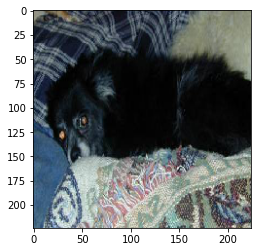

In [5]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
idx = random.randint(0, len(df)-1)
img = load_img(df["path"][idx], target_size=(224, 224))
plt.imshow(img)

In [6]:
#偷東西,遷移開始
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
# 5~6行要做freeze,把參數固定 compile前就要做: layer.trainable = False
for l in vgg.layers:
    l.trainable = False
layers = [
    #計算NB就是filter*4 一張圖(4[原本平均, 原本標準差, 新平均, 新標準差]) * 512 = 2048
    # 1024: trainable 1024: non-trainable, 只有1024需要訓練參數 
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
layers = vgg.layers + layers
model = Sequential(layers)
model.summary()
#至此, 遷移學習model結束, 已經完整將VGG16已經訓練好的模型直接套用. 所以Non-trainable params: 14,714,688固定住, 只需要訓練Trainable params: 3,211,650(25088*128+128 +258)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [8]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
x, y = np.array(df["path"]), np.array(df["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [10]:
#預處理,要用VGG16的預處理,參考連結

# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
# https://github.com/keras-team/keras-applications/tree/master/keras_applications
from tensorflow.keras.applications.vgg16 import preprocess_input

def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), size=batch)
    imgs, imgs_pre, ans = [], [], y[idx]
    for p in x[idx]: #p->path
        img = load_img(p, target_size=(224, 224))
        img = np.array(img)
        imgs.append(img)
        imgs_pre.append(preprocess_input(img))
    imgs, imgs_pre, ans = np.array(imgs), np.array(imgs_pre), np.array(ans)
    return (imgs, imgs_pre, ans)
a, b, c = get_data(x, y)
print(a.shape, b.shape, c.shape)

(20, 224, 224, 3) (20, 224, 224, 3) (20,)


In [11]:

for i in range(150): #訓練150次
    print("-" * 15, i, "-" * 15)
    img, imgp, ans = get_data(x_train, y_train, batch=20)
    result = model.train_on_batch(imgp, ans)
    print("[Train]:", result)
    img, imgp, ans = get_data(x_test, y_test, batch=100)
    result = model.test_on_batch(imgp, ans)
    print("[Validate]:", result)

--------------- 0 ---------------
[Train]: [0.6972299218177795, 0.6000000238418579]
[Validate]: [1.2364972829818726, 0.7400000095367432]
--------------- 1 ---------------
[Train]: [0.6539772748947144, 0.699999988079071]
[Validate]: [0.7900873422622681, 0.7400000095367432]
--------------- 2 ---------------
[Train]: [0.635927140712738, 0.6000000238418579]
[Validate]: [0.9384920597076416, 0.6299999952316284]
--------------- 3 ---------------
[Train]: [0.5841800570487976, 0.75]
[Validate]: [0.9299349188804626, 0.6200000047683716]
--------------- 4 ---------------
[Train]: [0.5394061803817749, 0.800000011920929]
[Validate]: [0.570038378238678, 0.7200000286102295]
--------------- 5 ---------------
[Train]: [0.5014342069625854, 0.800000011920929]
[Validate]: [0.7443726062774658, 0.6499999761581421]
--------------- 6 ---------------
[Train]: [0.554259181022644, 0.8999999761581421]
[Validate]: [0.7142587304115295, 0.699999988079071]
--------------- 7 ---------------
[Train]: [0.5283619165420532

In [12]:
img, imgp, ans = get_data(x_test, y_test, batch=500)
model.evaluate(imgp, ans)

16/16 [==============================] - 3s 121ms/step - loss: 0.1253 - accuracy: 0.9740


[0.1253410428762436, 0.9739999771118164]

In [13]:
model.predict(imgp)

array([[8.67285013e-01, 1.32714972e-01],
       [2.57190764e-02, 9.74280894e-01],
       [1.78946853e-02, 9.82105255e-01],
       [4.99611767e-03, 9.95003879e-01],
       [1.78105887e-02, 9.82189476e-01],
       [9.81767595e-01, 1.82323810e-02],
       [8.92241672e-03, 9.91077662e-01],
       [5.46507575e-02, 9.45349276e-01],
       [9.94346797e-01, 5.65313315e-03],
       [9.81288195e-01, 1.87117718e-02],
       [9.98291094e-03, 9.90017116e-01],
       [1.96866542e-02, 9.80313361e-01],
       [4.14385237e-02, 9.58561420e-01],
       [3.49235654e-01, 6.50764406e-01],
       [9.88283515e-01, 1.17164124e-02],
       [6.50913194e-02, 9.34908628e-01],
       [5.74229984e-03, 9.94257689e-01],
       [8.91464710e-01, 1.08535320e-01],
       [1.70749985e-02, 9.82924938e-01],
       [1.61186070e-03, 9.98388171e-01],
       [5.57463288e-01, 4.42536771e-01],
       [9.96574759e-01, 3.42527288e-03],
       [2.65879687e-02, 9.73412037e-01],
       [6.98924065e-01, 3.01075965e-01],
       [9.885603

In [14]:
pre = model.predict_classes(imgp)
pre

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,

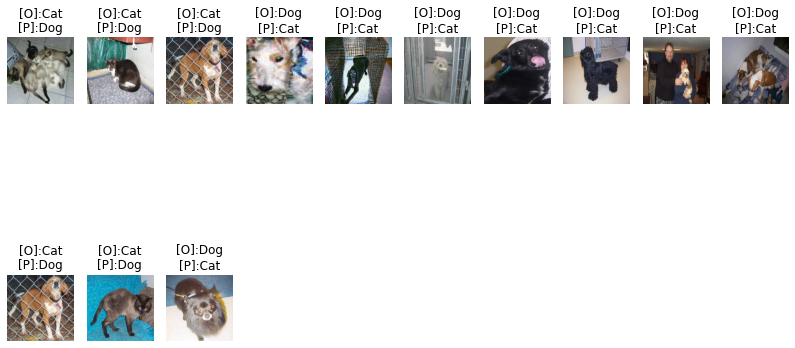

In [15]:
import numpy as np
# !!
y_test = ans
labels = ["Dog", "Cat"]
x_test = img

idx = np.nonzero(pre != y_test)[0]
idx = idx[:200]
false_pre = pre[idx]
false_ori = y_test[idx]
false_img = x_test[idx]

plt.figure(figsize=(14, 8))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(labels[false_ori[i]], labels[false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(false_img[i])